## Generate data

First we will generate a toy dataset that will mimic a set of documents in a systematic review that have been screened using ML prioritisation

,relevance,id
0,1.0,0
1,1.0,1
2,1.0,2
3,1.0,3
4,1.0,4


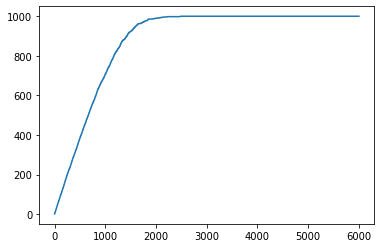

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

n_docs = 6000
n_relevant_docs = 1000
urn_bias = 20

sample = np.zeros(n_docs)
sample[:n_relevant_docs] = 1

ps = np.ones(n_docs)
ps[:n_relevant_docs] = urn_bias
ps = ps/ps.sum()

sample = np.random.choice(sample,sample.shape,replace=False, p=ps)
df = pd.DataFrame({'relevance': sample})
df['id'] = df.index
df.relevance.cumsum().plot()
df.head()


`df` is simply a dataframe with an id variable, and a binary relevance variable. We will create a column `seen_relevance` which will mirror the value of relevance given a case where X documents have not yet been screened. We will set the last X values of seen_relevance to NA. This mirrors a real database where the value of seen_relevance is 
- 1, where a user marked it for inclusion, 
- 0, where a user marked it for exclusion, and 
- NA, where a user has not yet seen the document

<Axes: >

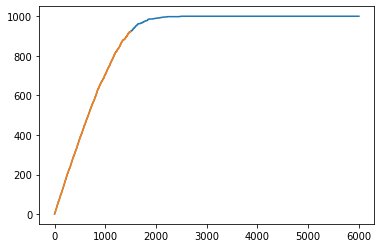

In [2]:
documents_seen = 1500
df['seen_relevance'] = np.NaN
df.loc[:documents_seen,'seen_relevance'] = df.loc[:documents_seen,'relevance']
df.relevance.cumsum().plot()
df.seen_relevance.cumsum().plot()


## Test null hypothesis

Now we can apply a function that tests the null hypothesis that a given recall target has been missed and returns a p score. This is simply applied to a dataframe where the value of `seen_relevance` takes the possible values described above.

We'll do a small "simulation", where we start with all rows of seen_relevance set to NA, then for batches of size `batch_size`, we "reveal" the values. We'll plt the p score after each batch

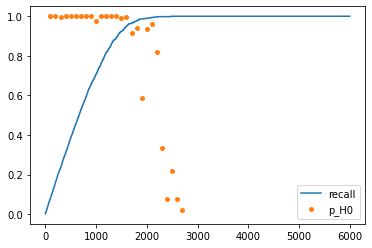

In [6]:
from scipy.stats import hypergeom

def calculate_h0(df, recall_target=.95):
    r_seen = df.seen_relevance.sum() # how many relevant docs have been seen
    urns = df[pd.notna(df.seen_relevance)].seen_relevance[::-1] # urns of previous 1,2,...,N documents
    urn_sizes = np.arange(urns.shape[0])+1 # The sizes of these urns
    # Now we calculate k_hat, which is the minimum number of documents there would have to be
    # in each of our urns for the urn to be in keeping with our null hypothesis
    # that we have missed our target
    k_hat = np.floor(
        r_seen/recall_target +1 - # We devide the number or relevant documents by our recall target and add 1
        (
            r_seen - # From this we subtract the total relevant documents seen
            urns.cumsum() # before each urn 
        )
    )
    p = hypergeom.cdf( # the probability of observing
        urns.cumsum(), # the number of relevant documents in the sample
        df.shape[0] - (urns.shape[0] - urn_sizes), # In a population made up out of the urn and all remaining docs 
        k_hat, # Where K_hat docs in the population are actually relevant
        urn_sizes # After observing this many documents
    )
    return min(p)


df['seen_relevance'] = np.NaN

fig, ax = plt.subplots()

df['recall'] = df.relevance.cumsum() / df.relevance.sum()
df.recall.plot(ax=ax, label='recall')

batch_size = 100 # We'll calculate our p score for H0 after each batch
for documents_seen in np.arange(df.shape[0])[batch_size::batch_size]:
    df.loc[:documents_seen,'seen_relevance'] = df.loc[:documents_seen,'relevance']
    p_h0 = calculate_h0(df)
    ax.scatter(
        documents_seen, p_h0, s=15,
        color="C1", label='p_H0' if documents_seen==batch_size else None
    )
    if p_h0 < 0.05:
        break
        
ax.legend()